# Question: What is the probability of a residential property in NYC failing its rodent inspection given past inspections of near by properties and restaurants?

## Imports and Socrata API set-up

In [0]:
# Imports

import os
import pandas as pd
import numpy as np

from sodapy import Socrata

In [0]:
# Rodent Inspection endpoint --> https://data.cityofnewyork.us/resource/p937-wjvj.json
# Restaurant Inspection endpoint --> https://data.cityofnewyork.us/resource/43nn-pn8j.json

# Enter the information from those sections here
domain = 'data.cityofnewyork.us'
rodent_key = 'p937-wjvj'
restaurant_key = '43nn-pn8j'

# Socrata app token to bypass throttling limits
socrata_token = os.environ.get("SODAPY_APPTOKEN")

In [0]:
client = Socrata(domain, socrata_token, timeout=25)

print("Domain: {domain:}\nSession: {session:}\nURI Prefix: {uri_prefix:}".format(**client.__dict__))

Domain: data.cityofnewyork.us
Session: <requests.sessions.Session object at 0x7fe36b25c310>
URI Prefix: https://


## Pull in the rodent inspection data

In [0]:
# Limit parameter will define how many rows of observations you get. Default limit is 1000
data = client.get(rodent_key, limit=2000000)

# Pull in the rodent inspection data as a df
rodents_df = pd.DataFrame.from_dict(data)

In [0]:
rodents_df.isnull().any().value_counts()

True     16
False     9
dtype: int64

In [0]:
rodents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1841657 entries, 0 to 1841656
Data columns (total 25 columns):
 #   Column                       Dtype 
---  ------                       ----- 
 0   inspection_type              object
 1   job_ticket_or_work_order_id  object
 2   job_id                       object
 3   job_progress                 object
 4   bbl                          object
 5   boro_code                    object
 6   block                        object
 7   lot                          object
 8   house_number                 object
 9   street_name                  object
 10  zip_code                     object
 11  x_coord                      object
 12  y_coord                      object
 13  latitude                     object
 14  longitude                    object
 15  borough                      object
 16  inspection_date              object
 17  result                       object
 18  approved_date                object
 19  location             

In [0]:
# Drop unknown 'computed region' columns .. have no clue what these are. Don't like the format of how they combined
# the latitude and longitude values in the 'location' column so dropping that too. Will do my own concatenation.

rodents_df = rodents_df.drop(['location', ':@computed_region_sbqj_enih',
       ':@computed_region_92fq_4b7q', ':@computed_region_f5dn_yrer',
       ':@computed_region_yeji_bk3q', ':@computed_region_efsh_h5xi'], axis=1, errors='ignore')

In [0]:
# Validate columns again
rodents_df.columns

Index(['inspection_type', 'job_ticket_or_work_order_id', 'job_id',
       'job_progress', 'bbl', 'boro_code', 'block', 'lot', 'house_number',
       'street_name', 'zip_code', 'x_coord', 'y_coord', 'latitude',
       'longitude', 'borough', 'inspection_date', 'result', 'approved_date'],
      dtype='object')

CSV the raw rodent inspection data for export to AWS

In [0]:
rodents_df.to_csv('/home/minh/metis/data/rodent_inspections-20200201.csv', index=False)

## Pull in restaurant inspection data

In [0]:
# Limit parameter will define how many rows of observations you get. Default limit is 1000
rest_data = client.get(restaurant_key, limit=500000)
restaurants_df = pd.DataFrame.from_dict(rest_data)

In [0]:
restaurants_df.isnull().any().value_counts()

True     20
False     6
dtype: int64

In [0]:
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400720 entries, 0 to 400719
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   camis                  400720 non-null  object
 1   dba                    400307 non-null  object
 2   boro                   400720 non-null  object
 3   building               400465 non-null  object
 4   street                 400720 non-null  object
 5   zipcode                395194 non-null  object
 6   phone                  400703 non-null  object
 7   cuisine_description    400720 non-null  object
 8   inspection_date        400720 non-null  object
 9   action                 399268 non-null  object
 10  violation_code         394963 non-null  object
 11  violation_description  391600 non-null  object
 12  critical_flag          391600 non-null  object
 13  score                  383708 non-null  object
 14  grade                  202533 non-null  object
 15  

In [0]:
restaurants_df.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'score', 'grade',
       'grade_date', 'record_date', 'inspection_type', 'latitude', 'longitude',
       'community_board', 'council_district', 'census_tract', 'bin', 'bbl',
       'nta'],
      dtype='object')

Feed raw restaurant inspection data to AWS

In [0]:
# Write to csv for export to AWS-hosted postgres DB
restaurants_df.to_csv('/home/minh/metis/data/restaurant_inspections-20200201.csv', index=False)

# Rodent inspection data EDA

Read in the rodent inspection data and store as a dataframe

In [0]:
import sqlalchemy as sqla
from sqlalchemy import *
dbpasswd = os.environ.get("dbpwd")

In [0]:
def conn_details(db, user, host, port, passwd):
    url = 'postgresql://{user}:{passwd}@{host}:{port}/{db}'.format(user=user, passwd=passwd, host=host, port=port, db=db)
    return url

In [0]:
conn_details('project3', 'ubuntu', 'ip', 'port', dbpasswd)

In [0]:
engine = sqla.create_engine(conn_details('project3', 'ubuntu', 'ip', 'port', dbpasswd))

In [0]:
rodents = pd.read_sql("select * from rodents where inspection_date >= '2013-01-01' limit 2000000", con=engine)

In [0]:
rodents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338679 entries, 0 to 1338678
Data columns (total 20 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   inspection_type  1338679 non-null  object 
 1   job_ticket       1338679 non-null  int64  
 2   job_id           1338679 non-null  object 
 3   visit_num        1338679 non-null  int64  
 4   bbl              1338679 non-null  int64  
 5   boro_code        1338679 non-null  object 
 6   block            1338679 non-null  object 
 7   lot              1338679 non-null  object 
 8   house_number     1313960 non-null  object 
 9   street_name      1337594 non-null  object 
 10  zip_code         1332526 non-null  object 
 11  x_coord          1331520 non-null  float64
 12  y_coord          1331520 non-null  float64
 13  latitude         1338459 non-null  float64
 14  longitude        1338459 non-null  float64
 15  borough          1338679 non-null  object 
 16  inspection_date  1

Check for whitespace issues

In [0]:
rodents.columns

Index(['inspection_type', 'job_ticket', 'job_id', 'visit_num', 'bbl',
       'boro_code', 'block', 'lot', 'house_number', 'street_name', 'zip_code',
       'x_coord', 'y_coord', 'latitude', 'longitude', 'borough',
       'inspection_date', 'insp_result', 'approved_date', 'prop_type'],
      dtype='object')

In [0]:
rodents.shape

(1338679, 20)

Since we're trying to figure out if a property will pass inspection or not, the 'result' column is important
so need to ensure that it does not have a substantial amount of NULLs.

In [0]:
rodents.insp_result.isna().value_counts()

False    1338671
True           8
Name: insp_result, dtype: int64

In [0]:
# Check to see if any other columns have null entries
rodents.isna().sum()

inspection_type        0
job_ticket             0
job_id                 0
visit_num              0
bbl                    0
boro_code              0
block                  0
lot                    0
house_number       24719
street_name         1085
zip_code            6153
x_coord             7159
y_coord             7159
latitude             220
longitude            220
borough                0
inspection_date        0
insp_result            8
approved_date          2
prop_type              0
dtype: int64

In [0]:
rodents = rodents.dropna()

In [0]:
rodents.reset_index(drop=True, inplace=True)

In [0]:
# Check to see if any other columns have null entries
rodents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302033 entries, 0 to 1302032
Data columns (total 20 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   inspection_type  1302033 non-null  object 
 1   job_ticket       1302033 non-null  int64  
 2   job_id           1302033 non-null  object 
 3   visit_num        1302033 non-null  int64  
 4   bbl              1302033 non-null  int64  
 5   boro_code        1302033 non-null  object 
 6   block            1302033 non-null  object 
 7   lot              1302033 non-null  object 
 8   house_number     1302033 non-null  object 
 9   street_name      1302033 non-null  object 
 10  zip_code         1302033 non-null  object 
 11  x_coord          1302033 non-null  float64
 12  y_coord          1302033 non-null  float64
 13  latitude         1302033 non-null  float64
 14  longitude        1302033 non-null  float64
 15  borough          1302033 non-null  object 
 16  inspection_date  1

In [0]:
rodents.inspection_date.dtype

dtype('O')

In [0]:
# rodents['inspection_date'] = rodents['inspection_date'].str[0:10]

In [0]:
rodents['inspection_date'] = pd.to_datetime(rodents.inspection_date)

In [0]:
rodents.head()

,inspection_type,job_ticket,job_id,visit_num,bbl,boro_code,block,lot,house_number,street_name,zip_code,x_coord,y_coord,latitude,longitude,borough,inspection_date,insp_result,approved_date,prop_type
0,COMPLIANCE,766936,PO741436,2,3030700025,3,03070,0025,123,GRAHAM AVENUE,11206,1000052.0,196517.0,40.706049,-73.943006,Brooklyn,2014-04-01,Passed Inspection,2014-04-04T12:58:36.000,property
1,INITIAL,988113,PO988113,1,1011210064,1,01121,0064,76,WEST 69 STREET,10023,989750.0,221705.0,40.775288,-73.979788,Manhattan,2015-06-11,Passed Inspection,2015-06-12T11:51:41.000,property
2,INITIAL,1487210,PO1487210,1,3031480031,3,03148,0031,1000,FLUSHING AVENUE,11206,1003331.0,195609.0,40.703707,-73.931279,Brooklyn,2017-09-07,Passed Inspection,2017-09-11T12:11:11.000,property
3,INITIAL,1447948,PO1447948,1,1012260039,1,01226,0039,106,WEST 96 STREET,10025,993088.0,228219.0,40.793074,-73.968081,Manhattan,2017-06-28,Active Rat Signs,2017-07-05T08:18:30.000,property
4,INITIAL,2079650,PO2079650,1,3059310072,3,05931,0072,539,BAY RIDGE PARKWAY,11209,978244.0,168400.0,40.628887,-74.021637,Brooklyn,2019-08-21,Problem Conditions,2019-08-22T11:14:32.000,property


Clean the dataframe and drop non-essential features like identifiers that really have no bearing on what we want to predict.

In [0]:
# Dropping un-needed/redundant columns
rodents = rodents.drop(['job_id', 'bbl', 'approved_date', 'house_number', 'street_name', 'zip_code', 'x_coord', 'y_coord'], axis=1, errors='ignore')

In [0]:
# If a site did not have a passing inspection result then rodents_present = 1, else 0
rodents['rodents_present'] = np.where(rodents['insp_result']!='Passed Inspection', 1, 0)

In [0]:
rodents.head()

,inspection_type,job_ticket,visit_num,boro_code,block,lot,latitude,longitude,borough,inspection_date,insp_result,prop_type,rodents_present
0,COMPLIANCE,766936,2,3,03070,0025,40.706049,-73.943006,Brooklyn,2014-04-01,Passed Inspection,property,0
1,INITIAL,988113,1,1,01121,0064,40.775288,-73.979788,Manhattan,2015-06-11,Passed Inspection,property,0
2,INITIAL,1487210,1,3,03148,0031,40.703707,-73.931279,Brooklyn,2017-09-07,Passed Inspection,property,0
3,INITIAL,1447948,1,1,01226,0039,40.793074,-73.968081,Manhattan,2017-06-28,Active Rat Signs,property,1
4,INITIAL,2079650,1,3,05931,0072,40.628887,-74.021637,Brooklyn,2019-08-21,Problem Conditions,property,1


# Introduce distance between locations

In [0]:
import geopy as gp
from geopy import distance

In [0]:
rodents['lat_long'] = rodents['latitude'].astype(str) + ',' + rodents['longitude'].astype(str)

In [0]:
rodents.head()

,inspection_type,job_ticket,visit_num,boro_code,block,lot,latitude,longitude,borough,inspection_date,insp_result,prop_type,rodents_present,lat_long
0,COMPLIANCE,766936,2,3,03070,0025,40.706049,-73.943006,Brooklyn,2014-04-01,Passed Inspection,property,0,"40.706049491212,-73.943005539458"
1,INITIAL,988113,1,1,01121,0064,40.775288,-73.979788,Manhattan,2015-06-11,Passed Inspection,property,0,"40.775287540723,-73.97978812919"
2,INITIAL,1487210,1,3,03148,0031,40.703707,-73.931279,Brooklyn,2017-09-07,Passed Inspection,property,0,"40.703707262198,-73.931278687281"
3,INITIAL,1447948,1,1,01226,0039,40.793074,-73.968081,Manhattan,2017-06-28,Active Rat Signs,property,1,"40.793073623626,-73.968081381798"
4,INITIAL,2079650,1,3,05931,0072,40.628887,-74.021637,Brooklyn,2019-08-21,Problem Conditions,property,1,"40.628886710297,-74.021637223865"


In [0]:
# Get distance between each location in feet
rodents['distance'] = rodents.apply(lambda x: gp.distance.distance(x['lat_long'],(rodents.iloc[x.name - 1].lat_long)).miles if x.name > 0 else 0,axis=1)

# Group by for failed inspections within n distance

In [0]:
rodents.head()

,inspection_type,job_ticket,visit_num,boro_code,block,lot,latitude,longitude,borough,inspection_date,insp_result,prop_type,rodents_present,lat_long,distance
0,COMPLIANCE,766936,2,3,03070,0025,40.706049,-73.943006,Brooklyn,2014-04-01,Passed Inspection,property,0,"40.706049491212,-73.943005539458",0.000000
1,INITIAL,988113,1,1,01121,0064,40.775288,-73.979788,Manhattan,2015-06-11,Passed Inspection,property,0,"40.775287540723,-73.97978812919",5.152888
2,INITIAL,1487210,1,3,03148,0031,40.703707,-73.931279,Brooklyn,2017-09-07,Passed Inspection,property,0,"40.703707262198,-73.931278687281",5.556798
3,INITIAL,1447948,1,1,01226,0039,40.793074,-73.968081,Manhattan,2017-06-28,Active Rat Signs,property,1,"40.793073623626,-73.968081381798",6.461882
4,INITIAL,2079650,1,3,05931,0072,40.628887,-74.021637,Brooklyn,2019-08-21,Problem Conditions,property,1,"40.628886710297,-74.021637223865",11.673038


In [0]:
nearby_failures = rodents[['boro_code', 'block', 'lot', 'rodents_present', 'distance']]

In [0]:
nearby_failures.head()

,boro_code,block,lot,rodents_present,distance
0,3,03070,0025,0,0.000000
1,1,01121,0064,0,5.152888
2,3,03148,0031,0,5.556798
3,1,01226,0039,1,6.461882
4,3,05931,0072,1,11.673038


In [0]:
two_fifty_ft = nearby_failures.loc[(nearby_failures['distance'] <= 0.05) & (nearby_failures['rodents_present'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
five_hundred_ft = nearby_failures.loc[(nearby_failures['distance'] <= 0.10) & (nearby_failures['rodents_present'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
thousand_ft = nearby_failures.loc[(nearby_failures['distance'] <= 0.20) & (nearby_failures['rodents_present'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
qtr_mile = nearby_failures.loc[(nearby_failures['distance'] <= 0.25) & (nearby_failures['rodents_present'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
half_mile = nearby_failures.loc[(nearby_failures['distance'] <= 0.50) & (nearby_failures['rodents_present'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
mile = nearby_failures.loc[(nearby_failures['distance'] <= 1.0) & (nearby_failures['rodents_present'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
# gp.distance.distance("40.781304405002,-73.981970877965","40.719048713507,-73.989899017585").miles

In [0]:
two_fifty_ft.head()

rodents_present  distance
boro_code block lot                            
1         00117 0100                3         3
          00119 0001                1         1
          00155 0031                1         1
          00160 0021                1         1
          00199 0011                1         1

In [0]:
# Join groupby back to original rodents dataframe
j1 = rodents.join(two_fifty_ft[['rodents_present']], on=(['boro_code', 'block', 'lot']), rsuffix='_250')

In [0]:
# Join 
j2 = j1.join(five_hundred_ft[['rodents_present']], on=(['boro_code', 'block', 'lot']), rsuffix='_500')

In [0]:
j3 = j2.join(thousand_ft[['rodents_present']], on=(['boro_code', 'block', 'lot']), rsuffix='_1000')

In [0]:
j4 = j3.join(qtr_mile[['rodents_present']], on=(['boro_code', 'block', 'lot']), rsuffix='_qtr_mile')

In [0]:
j5 = j4.join(half_mile[['rodents_present']], on=(['boro_code', 'block', 'lot']), rsuffix='_half_mile')

In [0]:
j6 = j5.join(mile[['rodents_present']], on=(['boro_code', 'block', 'lot']), rsuffix='_mile')

In [0]:
j6.info()

In [0]:
j6[j6.rodents_present_mile == 1]

,inspection_type,job_ticket,visit_num,boro_code,block,lot,latitude,longitude,borough,inspection_date,...,prop_type,rodents_present,lat_long,distance,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile
14,BAIT,217596,3,3,01485,0021,40.687211,-73.922242,Brooklyn,2015-08-04,...,property,1,"40.68721089037,-73.92224167596",0.917052,NaN,NaN,NaN,NaN,NaN,1.0
18,INITIAL,2004370,1,1,02035,0001,40.825749,-73.939618,Manhattan,2019-05-06,...,property,1,"40.825749364021,-73.939618126441",10.170411,NaN,NaN,NaN,NaN,NaN,1.0
22,INITIAL,1834146,1,2,03050,0030,40.854420,-73.893000,Bronx,2018-11-01,...,property,0,"40.854419874603,-73.892999990045",1.267593,NaN,NaN,NaN,NaN,NaN,1.0
25,COMPLIANCE,1141759,2,2,02744,0039,40.826024,-73.890907,Bronx,2016-04-28,...,property,1,"40.826023587659,-73.890906744183",3.314049,NaN,NaN,NaN,NaN,1.0,1.0
26,BAIT,243140,9,1,02227,0001,40.866876,-73.920256,Manhattan,2016-02-22,...,property,1,"40.866875650035,-73.920255550517",3.211164,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301978,INITIAL,1601364,1,1,00463,0051,40.728727,-73.989872,Manhattan,2018-01-22,...,property,0,"40.728726758723,-73.989872288809",2.318139,NaN,NaN,NaN,NaN,NaN,1.0
1301981,INITIAL,675714,1,2,03186,0049,40.857836,-73.904201,Bronx,2013-07-29,...,property,1,"40.85783597112,-73.904201137651",10.464865,NaN,NaN,NaN,NaN,NaN,1.0
1301999,INITIAL,897188,1,1,02115,0047,40.832610,-73.943366,Manhattan,2014-12-02,...,property,0,"40.832610379027,-73.943366484756",2.518445,NaN,NaN,NaN,NaN,NaN,1.0
1302014,BAIT,314155,4,2,03277,0001,40.863309,-73.889208,Bronx,2017-03-28,...,property,1,"40.863309214703,-73.889207589317",13.335995,NaN,NaN,NaN,NaN,1.0,1.0


In [0]:
j6 = j6.fillna(0)

In [0]:
rodents = j6

In [0]:
rodents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302033 entries, 0 to 1302032
Data columns (total 21 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   inspection_type            1302033 non-null  object        
 1   job_ticket                 1302033 non-null  int64         
 2   visit_num                  1302033 non-null  int64         
 3   boro_code                  1302033 non-null  object        
 4   block                      1302033 non-null  object        
 5   lot                        1302033 non-null  object        
 6   latitude                   1302033 non-null  float64       
 7   longitude                  1302033 non-null  float64       
 8   borough                    1302033 non-null  object        
 9   inspection_date            1302033 non-null  datetime64[ns]
 10  insp_result                1302033 non-null  object        
 11  prop_type                  1302033 no

In [0]:
rodents.astype({'rodents_present_250':'int','rodents_present_500':'int','rodents_present_1000':'int','rodents_present_qtr_mile':'int','rodents_present_half_mile':'int','rodents_present_mile':'int'}).dtypes 

inspection_type                      object
job_ticket                            int64
visit_num                             int64
boro_code                            object
block                                object
lot                                  object
latitude                            float64
longitude                           float64
borough                              object
inspection_date              datetime64[ns]
insp_result                          object
prop_type                            object
rodents_present                       int64
lat_long                             object
distance                            float64
rodents_present_250                   int64
rodents_present_500                   int64
rodents_present_1000                  int64
rodents_present_qtr_mile              int64
rodents_present_half_mile             int64
rodents_present_mile                  int64
dtype: object

In [0]:
rodents_final = rodents

In [0]:
rodents_final = rodents_final.rename(columns={'rodents_present':'rodents_present_residential'})

In [0]:
rodents_final.sample(100)

,inspection_type,job_ticket,visit_num,boro_code,block,lot,latitude,longitude,borough,inspection_date,...,prop_type,rodents_present_residential,lat_long,distance,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile
668169,INITIAL,1092825,1,1,01771,0056,40.802660,-73.938678,Manhattan,2016-01-14,...,property,0,"40.802660073383,-73.938678348534",3.472297,0.0,0.0,0.0,0.0,0.0,0.0
669189,INITIAL,1322541,1,1,01057,0023,40.761944,-73.991105,Manhattan,2017-02-02,...,property,0,"40.761943970086,-73.991105388785",6.843156,0.0,0.0,0.0,0.0,0.0,0.0
1207726,INITIAL,1822133,1,3,01803,0120,40.687773,-73.949959,Brooklyn,2018-10-18,...,property,0,"40.687772550793,-73.949958772912",1.511261,0.0,0.0,0.0,0.0,0.0,0.0
492486,INITIAL,1692033,1,3,01953,7502,40.688240,-73.958930,Brooklyn,2018-05-22,...,property,0,"40.688239982691,-73.958929703322",6.063973,0.0,0.0,0.0,0.0,0.0,0.0
359946,INITIAL,1410123,1,1,01564,0022,40.774841,-73.947925,Manhattan,2017-04-24,...,property,0,"40.774841091846,-73.947925354507",4.597378,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869559,INITIAL,1608068,1,2,02802,0065,40.847459,-73.905225,Bronx,2018-01-10,...,property,0,"40.847458980384,-73.905224581798",2.743166,0.0,0.0,0.0,0.0,0.0,0.0
537657,INITIAL,1330878,1,3,01596,0161,40.694304,-73.932388,Brooklyn,2017-02-23,...,property,0,"40.694304330908,-73.932388292394",0.481632,0.0,0.0,0.0,0.0,0.0,0.0
528190,INITIAL,1890639,1,2,03104,0061,40.853796,-73.883230,Bronx,2018-12-20,...,property,1,"40.85379554257,-73.88323010414",2.241225,1.0,1.0,1.0,1.0,2.0,9.0
197695,INITIAL,990444,1,2,02436,0024,40.834888,-73.911733,Bronx,2015-06-24,...,property,0,"40.834887777158,-73.911732945304",18.084505,0.0,0.0,0.0,0.0,0.0,0.0


# Restaurant inspection data EDA

In [0]:
restaurants = pd.read_sql("select * from restaurants where inspection_date >= '2013-01-01'", con=engine)

In [0]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398672 entries, 0 to 398671
Data columns (total 30 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   camis                  398672 non-null  int64  
 1   dba                    398672 non-null  object 
 2   boro                   398672 non-null  object 
 3   building               398436 non-null  object 
 4   street                 398672 non-null  object 
 5   zipcode                393152 non-null  object 
 6   phone                  398656 non-null  object 
 7   cuisine_description    398672 non-null  object 
 8   inspection_date        398672 non-null  object 
 9   action                 398672 non-null  object 
 10  violation_code         394327 non-null  object 
 11  violation_description  390966 non-null  object 
 12  critical_flag          390966 non-null  object 
 13  record_date            398672 non-null  object 
 14  inspection_type        398672 non-nu

In [0]:
restaurants.action.isnull().value_counts()

False    398672
Name: action, dtype: int64

In [0]:
restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'record_date',
       'inspection_type', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'score',
       'grade', 'grade_date', 'boro_code', 'block', 'lot', 'prop_type'],
      dtype='object')

Unlike the rodents data set, the restaurant data set does not split up the bbl code into borough-block-lot. Need to do this manually so we can properly group boroughs and block together in addition to having a common column to join the two tables together.

In [0]:
restaurants['bbl'] = restaurants['bbl'].fillna(0)

In [0]:
restaurants['bbl'] = restaurants.bbl.astype(int)

In [0]:
restaurants['bbl'] = restaurants.bbl.astype(str)

In [0]:
restaurants['boro_code'] = restaurants['bbl'].str[0]

In [0]:
restaurants['block'] = restaurants['bbl'].str[1:6]

In [0]:
restaurants['lot'] = restaurants['bbl'].str[6:]

In [0]:
# Feed the dataframe back into the database with the newly added boro_code, block, and lot columns
# restaurants.to_csv('/home/minh/metis/data/restaurant_inspections-20200204.csv', index=False)

In [0]:
restaurants.columns

Index(['camis', 'dba', 'boro', 'building', 'street', 'zipcode', 'phone',
       'cuisine_description', 'inspection_date', 'action', 'violation_code',
       'violation_description', 'critical_flag', 'record_date',
       'inspection_type', 'latitude', 'longitude', 'community_board',
       'council_district', 'census_tract', 'bin', 'bbl', 'nta', 'score',
       'grade', 'grade_date', 'boro_code', 'block', 'lot', 'prop_type'],
      dtype='object')

In [0]:
# Rename "boro" to "borough" to match the rodents df
restaurants = restaurants.rename(columns={'boro':'borough'})

In [0]:
# Rename "boro" to "borough" to match the rodents df
restaurants = restaurants.rename(columns={'dba':'restaurant_name'})

In [0]:
restaurants.head()

,camis,restaurant_name,borough,building,street,zipcode,phone,cuisine_description,inspection_date,action,...,bin,bbl,nta,score,grade,grade_date,boro_code,block,lot,prop_type
0,41638429,STARBUCKS,Manhattan,977,AVENUE OF THE AMERICAS,10018,2126952915,Café/Coffee/Tea,2017-09-07,Violations were cited in the following area(s).,...,1080606.0,1008110031,MN17,18,None,None,1,00811,0031,restaurant
1,41687397,GOLDEN IMPERIAL SEAFOOD RESTAURANT,Brooklyn,618,62 STREET,11220,7188333777,Chinese,2017-12-05,Violations were cited in the following area(s).,...,3339452.0,3058020001,BK34,13,A,2017-12-05T00:00:00.000,3,05802,0001,restaurant
2,50092887,HERBALIFE NUTRICION CENTER GUTIERREZ,Bronx,624,MELROSE AVE,10455,6465084675,"Juice, Smoothies, Fruit Salads",2019-07-01,Violations were cited in the following area(s).,...,2001345.0,2023740034,BX34,10,None,None,2,02374,0034,restaurant
3,50053083,PELICANA CHICKEN,Queens,4708,GREENPOINT AVE,11104,3477179001,Korean,2019-09-10,Violations were cited in the following area(s).,...,4001515.0,4001510030,QN31,11,A,2019-09-10T00:00:00.000,4,00151,0030,restaurant
4,41101663,EL VALLE RESTAURANT,Bronx,1000,WESTCHESTER AVENUE,10459,7188608300,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-06-14,Violations were cited in the following area(s).,...,2005770.0,2027240032,BX27,18,None,None,2,02724,0032,restaurant


In [0]:
# Get rid of un-needed/redundant columns
restaurants = restaurants.drop(['camis', 'building', 'bin', 'street', 'zipcode', 'phone', 'violation_description', 'record_date', 'inspection_type', 'community_board', 'council_district', 'census_tract', 'bbl', 'nta', 'grade', 'grade_date'], axis=1, errors='ignore')

In [0]:
restaurants.head()

,restaurant_name,borough,cuisine_description,inspection_date,action,violation_code,critical_flag,latitude,longitude,score,boro_code,block,lot,prop_type
0,STARBUCKS,Manhattan,Café/Coffee/Tea,2017-09-07,Violations were cited in the following area(s).,04N,Y,40.750956,-73.986945,18,1,00811,0031,restaurant
1,GOLDEN IMPERIAL SEAFOOD RESTAURANT,Brooklyn,Chinese,2017-12-05,Violations were cited in the following area(s).,09B,N,40.636631,-74.014542,13,3,05802,0001,restaurant
2,HERBALIFE NUTRICION CENTER GUTIERREZ,Bronx,"Juice, Smoothies, Fruit Salads",2019-07-01,Violations were cited in the following area(s).,04M,Y,40.817891,-73.916929,10,2,02374,0034,restaurant
3,PELICANA CHICKEN,Queens,Korean,2019-09-10,Violations were cited in the following area(s).,08A,N,40.742553,-73.917662,11,4,00151,0030,restaurant
4,EL VALLE RESTAURANT,Bronx,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-06-14,Violations were cited in the following area(s).,10F,N,40.823685,-73.893790,18,2,02724,0032,restaurant


In [0]:
restaurants['inspection_date'] = pd.to_datetime(restaurants.inspection_date)

In [0]:
restaurants.head()

,restaurant_name,borough,cuisine_description,inspection_date,action,violation_code,critical_flag,latitude,longitude,score,boro_code,block,lot,prop_type
0,STARBUCKS,Manhattan,Café/Coffee/Tea,2017-09-07,Violations were cited in the following area(s).,04N,Y,40.750956,-73.986945,18,1,00811,0031,restaurant
1,GOLDEN IMPERIAL SEAFOOD RESTAURANT,Brooklyn,Chinese,2017-12-05,Violations were cited in the following area(s).,09B,N,40.636631,-74.014542,13,3,05802,0001,restaurant
2,HERBALIFE NUTRICION CENTER GUTIERREZ,Bronx,"Juice, Smoothies, Fruit Salads",2019-07-01,Violations were cited in the following area(s).,04M,Y,40.817891,-73.916929,10,2,02374,0034,restaurant
3,PELICANA CHICKEN,Queens,Korean,2019-09-10,Violations were cited in the following area(s).,08A,N,40.742553,-73.917662,11,4,00151,0030,restaurant
4,EL VALLE RESTAURANT,Bronx,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-06-14,Violations were cited in the following area(s).,10F,N,40.823685,-73.893790,18,2,02724,0032,restaurant


In [0]:
restaurants.isna().sum()

restaurant_name            0
borough                    0
cuisine_description        0
inspection_date            0
action                     0
violation_code          4345
critical_flag           7706
latitude                 401
longitude                401
score                  15607
boro_code                  0
block                      0
lot                        0
prop_type                  0
dtype: int64

In [0]:
restaurants = restaurants.dropna()

In [0]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379907 entries, 0 to 398671
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   restaurant_name      379907 non-null  object        
 1   borough              379907 non-null  object        
 2   cuisine_description  379907 non-null  object        
 3   inspection_date      379907 non-null  datetime64[ns]
 4   action               379907 non-null  object        
 5   violation_code       379907 non-null  object        
 6   critical_flag        379907 non-null  object        
 7   latitude             379907 non-null  float64       
 8   longitude            379907 non-null  float64       
 9   score                379907 non-null  object        
 10  boro_code            379907 non-null  object        
 11  block                379907 non-null  object        
 12  lot                  379907 non-null  object        
 13  prop_type     

In [0]:
restaurants.head()

,restaurant_name,borough,cuisine_description,inspection_date,action,violation_code,critical_flag,latitude,longitude,score,boro_code,block,lot,prop_type
0,STARBUCKS,Manhattan,Café/Coffee/Tea,2017-09-07,Violations were cited in the following area(s).,04N,Y,40.750956,-73.986945,18,1,00811,0031,restaurant
1,GOLDEN IMPERIAL SEAFOOD RESTAURANT,Brooklyn,Chinese,2017-12-05,Violations were cited in the following area(s).,09B,N,40.636631,-74.014542,13,3,05802,0001,restaurant
2,HERBALIFE NUTRICION CENTER GUTIERREZ,Bronx,"Juice, Smoothies, Fruit Salads",2019-07-01,Violations were cited in the following area(s).,04M,Y,40.817891,-73.916929,10,2,02374,0034,restaurant
3,PELICANA CHICKEN,Queens,Korean,2019-09-10,Violations were cited in the following area(s).,08A,N,40.742553,-73.917662,11,4,00151,0030,restaurant
4,EL VALLE RESTAURANT,Bronx,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-06-14,Violations were cited in the following area(s).,10F,N,40.823685,-73.893790,18,2,02724,0032,restaurant


In [0]:
# Create a new column assigning 1 for any mice/rat violations (violation code = 04L or 04K) and 0 for none. 
# None does not imply no violations at all just none pertaining specifically to mice/rat problems
restaurants['rodents_present'] = np.where(restaurants['violation_code'].isin(['04L', '04K']), 1, 0)

In [0]:
# Create a new column assigning 1 for ANY restaurant violation code and 0 for no violations recorded
restaurants['non_rodent_violations'] = np.where(restaurants['action'] != 'No violations were recorded at the time of this inspection.', 1, 0)

In [0]:
restaurants.head()

,restaurant_name,borough,cuisine_description,inspection_date,action,violation_code,critical_flag,latitude,longitude,score,boro_code,block,lot,prop_type,rodents_present,non_rodent_violations
0,STARBUCKS,Manhattan,Café/Coffee/Tea,2017-09-07,Violations were cited in the following area(s).,04N,Y,40.750956,-73.986945,18,1,00811,0031,restaurant,0,1
1,GOLDEN IMPERIAL SEAFOOD RESTAURANT,Brooklyn,Chinese,2017-12-05,Violations were cited in the following area(s).,09B,N,40.636631,-74.014542,13,3,05802,0001,restaurant,0,1
2,HERBALIFE NUTRICION CENTER GUTIERREZ,Bronx,"Juice, Smoothies, Fruit Salads",2019-07-01,Violations were cited in the following area(s).,04M,Y,40.817891,-73.916929,10,2,02374,0034,restaurant,0,1
3,PELICANA CHICKEN,Queens,Korean,2019-09-10,Violations were cited in the following area(s).,08A,N,40.742553,-73.917662,11,4,00151,0030,restaurant,0,1
4,EL VALLE RESTAURANT,Bronx,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-06-14,Violations were cited in the following area(s).,10F,N,40.823685,-73.893790,18,2,02724,0032,restaurant,0,1


In [0]:
restaurants = restaurants.rename(columns={'rodents_present': 'rodents_present_restaurant'})

In [0]:
restaurants.head()

,restaurant_name,borough,cuisine_description,inspection_date,action,violation_code,critical_flag,latitude,longitude,score,boro_code,block,lot,prop_type,rodents_present_restaurant,non_rodent_violations
0,STARBUCKS,Manhattan,Café/Coffee/Tea,2017-09-07,Violations were cited in the following area(s).,04N,Y,40.750956,-73.986945,18,1,00811,0031,restaurant,0,1
1,GOLDEN IMPERIAL SEAFOOD RESTAURANT,Brooklyn,Chinese,2017-12-05,Violations were cited in the following area(s).,09B,N,40.636631,-74.014542,13,3,05802,0001,restaurant,0,1
2,HERBALIFE NUTRICION CENTER GUTIERREZ,Bronx,"Juice, Smoothies, Fruit Salads",2019-07-01,Violations were cited in the following area(s).,04M,Y,40.817891,-73.916929,10,2,02374,0034,restaurant,0,1
3,PELICANA CHICKEN,Queens,Korean,2019-09-10,Violations were cited in the following area(s).,08A,N,40.742553,-73.917662,11,4,00151,0030,restaurant,0,1
4,EL VALLE RESTAURANT,Bronx,"Latin (Cuban, Dominican, Puerto Rican, South &...",2017-06-14,Violations were cited in the following area(s).,10F,N,40.823685,-73.893790,18,2,02724,0032,restaurant,0,1


In [0]:
restaurants['lat_long'] = restaurants['latitude'].astype(str) + ',' + restaurants['longitude'].astype(str)

In [0]:
# # Get distance between each location in feet
# restaurants['rest_distance'] = restaurants.apply(lambda x: gp.distance.distance(x['lat_long'],(restaurants.iloc[x.name - 1].lat_long)).miles if x.name > 0 else 0,axis=1)

In [0]:
rodents_final.columns

Index(['inspection_type', 'job_ticket', 'visit_num', 'boro_code', 'block',
       'lot', 'latitude', 'longitude', 'borough', 'inspection_date',
       'insp_result', 'prop_type', 'rodents_present_residential', 'lat_long',
       'distance', 'rodents_present_250', 'rodents_present_500',
       'rodents_present_1000', 'rodents_present_qtr_mile',
       'rodents_present_half_mile', 'rodents_present_mile'],
      dtype='object')

In [0]:
restaurants.columns

Index(['restaurant_name', 'borough', 'cuisine_description', 'inspection_date',
       'action', 'violation_code', 'critical_flag', 'latitude', 'longitude',
       'score', 'boro_code', 'block', 'lot', 'prop_type',
       'rodents_present_restaurant', 'non_rodent_violations', 'lat_long'],
      dtype='object')

In [0]:
restaurants_small = restaurants[['borough', 'inspection_date', 'boro_code', 'block', 'lot', 'prop_type', 'rodents_present_restaurant', 'non_rodent_violations', 'latitude', 'longitude', 'lat_long']]

In [0]:
restaurants_small.head()

,borough,inspection_date,boro_code,block,lot,prop_type,rodents_present_restaurant,non_rodent_violations,latitude,longitude,lat_long
0,Manhattan,2017-09-07,1,00811,0031,restaurant,0,1,40.750956,-73.986945,"40.750956300473,-73.986945421284"
1,Brooklyn,2017-12-05,3,05802,0001,restaurant,0,1,40.636631,-74.014542,"40.636630863119,-74.014541792946"
2,Bronx,2019-07-01,2,02374,0034,restaurant,0,1,40.817891,-73.916929,"40.81789072144,-73.916929212149"
3,Queens,2019-09-10,4,00151,0030,restaurant,0,1,40.742553,-73.917662,"40.742553229627,-73.917662261718"
4,Bronx,2017-06-14,2,02724,0032,restaurant,0,1,40.823685,-73.893790,"40.823685024131,-73.893790306115"


In [0]:
merge_test = pd.concat([rodents, restaurants_small], ignore_index=True)

In [0]:
# merge_test.loc[(merge_test['lot']=='0031') & (merge_test['block']=='00811')]

In [0]:
merge_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681940 entries, 0 to 1681939
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   inspection_type             1302033 non-null  object        
 1   job_ticket                  1302033 non-null  float64       
 2   visit_num                   1302033 non-null  float64       
 3   boro_code                   1681940 non-null  object        
 4   block                       1681940 non-null  object        
 5   lot                         1681940 non-null  object        
 6   latitude                    1681940 non-null  float64       
 7   longitude                   1681940 non-null  float64       
 8   borough                     1681940 non-null  object        
 9   inspection_date             1681940 non-null  datetime64[ns]
 10  insp_result                 1302033 non-null  object        
 11  prop_type               

In [0]:
model_df = merge_test.drop(['job_ticket', 'prop_type', 'distance', 'borough','latitude', 'longitude', 'lat_long', 'inspection_date', 'insp_result'], axis=1, errors='ignore')

In [0]:
model_df.head()

,inspection_type,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant,non_rodent_violations
0,INITIAL,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,COMPLIANCE,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,COMPLIANCE,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,INITIAL,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,INITIAL,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [0]:
rest_df = restaurants[['boro_code', 'block', 'lot','rodents_present_restaurant', 'lat_long', 'non_rodent_violations']]

In [0]:
rode_df = rodents[['boro_code', 'block', 'lot', 'lat_long']]

In [0]:
rode_df.head()

,boro_code,block,lot,lat_long
0,3,01625,0070,"40.688769591954,-73.934928838927"
1,3,03193,0022,"40.696589226274,-73.934531699846"
2,2,02462,0042,"40.832324467893,-73.919588844128"
3,2,02582,0030,"40.8120309431,-73.90654323374"
4,4,05125,0026,"40.752232754353,-73.827536815738"


In [0]:
new_df = pd.concat([rode_df, rest_df], ignore_index=True)

In [0]:
new_df.head()

,boro_code,block,lot,lat_long,rodents_present_restaurant,non_rodent_violations
0,3,01625,0070,"40.688769591954,-73.934928838927",NaN,NaN
1,3,03193,0022,"40.696589226274,-73.934531699846",NaN,NaN
2,2,02462,0042,"40.832324467893,-73.919588844128",NaN,NaN
3,2,02582,0030,"40.8120309431,-73.90654323374",NaN,NaN
4,4,05125,0026,"40.752232754353,-73.827536815738",NaN,NaN


In [0]:
# Get distance between each location in feet
new_df['distance'] = new_df.apply(lambda x: gp.distance.distance(x['lat_long'],(new_df.iloc[x.name - 1].lat_long)).miles if x.name > 0 else 0,axis=1)

In [0]:
new_df.head()

,boro_code,block,lot,lat_long,rodents_present_restaurant,non_rodent_violations,distance
0,3,01625,0070,"40.688769591954,-73.934928838927",NaN,NaN,0.000000
1,3,03193,0022,"40.696589226274,-73.934531699846",NaN,NaN,0.539974
2,2,02462,0042,"40.832324467893,-73.919588844128",NaN,NaN,9.398875
3,2,02582,0030,"40.8120309431,-73.90654323374",NaN,NaN,1.558382
4,4,05125,0026,"40.752232754353,-73.827536815738",NaN,NaN,5.847942


In [0]:
two_fiftyft_rest = new_df.loc[(new_df['distance'] <= 0.05) & (new_df['rodents_present_restaurant'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
five_hundredft_rest = new_df.loc[(new_df['distance'] <= 0.10) & (new_df['rodents_present_restaurant'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
thousand_ft_rest = new_df.loc[(new_df['distance'] <= 0.20) & (new_df['rodents_present_restaurant'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
qtr_mile_rest = new_df.loc[(new_df['distance'] <= 0.25) & (new_df['rodents_present_restaurant'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
half_mile_rest = new_df.loc[(new_df['distance'] <= 0.50) & (new_df['rodents_present_restaurant'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
mile_rest = new_df.loc[(new_df['distance'] <= 1.0) & (new_df['rodents_present_restaurant'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
two_fiftyft_rest_any = new_df.loc[(new_df['distance'] <= 0.05) & (new_df['non_rodent_violations'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
five_hundredft_rest_any = new_df.loc[(new_df['distance'] <= 0.10) & (new_df['non_rodent_violations'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
thousand_ft_rest_any = new_df.loc[(new_df['distance'] <= 0.20) & (new_df['non_rodent_violations'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
qtr_mile_rest_any = new_df.loc[(new_df['distance'] <= 0.25) & (new_df['non_rodent_violations'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
half_mile_rest_any = new_df.loc[(new_df['distance'] <= 0.50) & (new_df['non_rodent_violations'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

In [0]:
mile_rest_any = new_df.loc[(new_df['distance'] <= 1.0) & (new_df['non_rodent_violations'] == 1)].groupby(['boro_code', 'block', 'lot']).count()

# Final data frame for modeling

In [0]:
# final_answer = model_df.drop(['rodents_present_restaurant', 'non_rodent_violations'], axis=1, errors='ignore')

In [0]:
final_answer = model_df

In [0]:
final_answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681940 entries, 0 to 1681939
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   inspection_type            1302033 non-null  object 
 1   visit_num                  1302033 non-null  float64
 2   boro_code                  1681940 non-null  object 
 3   block                      1681940 non-null  object 
 4   lot                        1681940 non-null  object 
 5   rodents_present            1302033 non-null  float64
 6   rodents_present_250        1302033 non-null  float64
 7   rodents_present_500        1302033 non-null  float64
 8   rodents_present_1000       1302033 non-null  float64
 9   rodents_present_qtr_mile   1302033 non-null  float64
 10  rodents_present_half_mile  1302033 non-null  float64
 11  rodents_present_mile       1302033 non-null  float64
dtypes: float64(8), object(4)
memory usage: 154.0+ MB


In [0]:
final_answer = final_answer.drop(['rodents_present_restaurant', 'non_rodent_violations'], axis=1, errors='ignore')

In [0]:
import pickle
final_answer.to_pickle('final_answer.pickle')

In [0]:
final_answer.head()

,inspection_type,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant,non_rodent_violations
0,INITIAL,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,COMPLIANCE,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,COMPLIANCE,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,INITIAL,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,INITIAL,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [0]:
final_answer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681940 entries, 0 to 1681939
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   inspection_type            1302033 non-null  object 
 1   visit_num                  1302033 non-null  float64
 2   boro_code                  1681940 non-null  object 
 3   block                      1681940 non-null  object 
 4   lot                        1681940 non-null  object 
 5   rodents_present            1302033 non-null  float64
 6   rodents_present_250        1302033 non-null  float64
 7   rodents_present_500        1302033 non-null  float64
 8   rodents_present_1000       1302033 non-null  float64
 9   rodents_present_qtr_mile   1302033 non-null  float64
 10  rodents_present_half_mile  1302033 non-null  float64
 11  rodents_present_mile       1302033 non-null  float64
dtypes: float64(8), object(4)
memory usage: 154.0+ MB


In [0]:
# Join groupby back to original rodents dataframe
final_answer = final_answer.join(two_fiftyft_rest[['rodents_present_restaurant']], on=(['boro_code', 'block', 'lot']), rsuffix='_250_rest')

In [0]:
# final_answer = final_answer.drop(['rodents_present_restaurant', 'non_rodent_violations'], axis=1, errors='ignore')

In [0]:
final_answer.head()

,inspection_type,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant
0,INITIAL,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,COMPLIANCE,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,COMPLIANCE,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,INITIAL,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,INITIAL,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [0]:
f1 = final_answer.join(five_hundredft_rest[['rodents_present_restaurant']], on=(['boro_code', 'block', 'lot']), rsuffix='_500_rest')

In [0]:
f1.head()

,inspection_type,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant,rodents_present_restaurant_500_rest
0,INITIAL,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,COMPLIANCE,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,COMPLIANCE,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,INITIAL,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,INITIAL,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [0]:
f2 = f1.join(thousand_ft_rest[['rodents_present_restaurant']], on=(['boro_code', 'block', 'lot']), rsuffix='_1000_rest')

In [0]:
f3 = f2.join(qtr_mile_rest[['rodents_present_restaurant']], on=(['boro_code', 'block', 'lot']), rsuffix='_qtr_mile_rest')

In [0]:
f4 = f3.join(half_mile_rest[['rodents_present_restaurant']], on=(['boro_code', 'block', 'lot']), rsuffix='_half_mile_rest')

In [0]:
f5 = f4.join(mile_rest[['rodents_present_restaurant']], on=(['boro_code', 'block', 'lot']), rsuffix='_mile_rest')

In [0]:
f5.rename(columns={'rodents_present_restaurant':'rodents_present_restaurant_250_rest'}, inplace=True)

In [0]:
f5.head()

,inspection_type,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant_250_rest,rodents_present_restaurant_500_rest,rodents_present_restaurant_1000_rest,rodents_present_restaurant_qtr_mile_rest,rodents_present_restaurant_half_mile_rest,rodents_present_restaurant_mile_rest
0,INITIAL,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,COMPLIANCE,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,COMPLIANCE,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,INITIAL,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,INITIAL,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
f6 = f5.join(two_fiftyft_rest_any[['non_rodent_violations']], on=(['boro_code', 'block', 'lot']), rsuffix='_250_rest_any')

In [0]:
f6.columns

Index(['inspection_type', 'visit_num', 'boro_code', 'block', 'lot',
       'rodents_present', 'rodents_present_250', 'rodents_present_500',
       'rodents_present_1000', 'rodents_present_qtr_mile',
       'rodents_present_half_mile', 'rodents_present_mile',
       'rodents_present_restaurant_250_rest',
       'rodents_present_restaurant_500_rest',
       'rodents_present_restaurant_1000_rest',
       'rodents_present_restaurant_qtr_mile_rest',
       'rodents_present_restaurant_half_mile_rest',
       'rodents_present_restaurant_mile_rest', 'non_rodent_violations'],
      dtype='object')

In [0]:
f7 = f6.join(five_hundredft_rest_any[['non_rodent_violations']], on=(['boro_code', 'block', 'lot']), rsuffix='_500_rest_any')

In [0]:
f8 = f7.join(thousand_ft_rest_any[['non_rodent_violations']], on=(['boro_code', 'block', 'lot']), rsuffix='_1000_rest_any')

In [0]:
f9 = f8.join(qtr_mile_rest_any[['non_rodent_violations']], on=(['boro_code', 'block', 'lot']), rsuffix='_qtr_mile_rest_any')

In [0]:
f10 = f9.join(half_mile_rest_any[['non_rodent_violations']], on=(['boro_code', 'block', 'lot']), rsuffix='_half_mile_rest_any')

In [0]:
f11 = f10.join(mile_rest_any[['non_rodent_violations']], on=(['boro_code', 'block', 'lot']), rsuffix='_mile_rest_any')

In [0]:
f11.rename(columns={'non_rodent_violations':'non_rodent_violations_250_rest_any'}, inplace=True)

In [0]:
f11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1681940 entries, 0 to 1681939
Data columns (total 24 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   inspection_type                            1302033 non-null  object 
 1   visit_num                                  1302033 non-null  float64
 2   boro_code                                  1681940 non-null  object 
 3   block                                      1681940 non-null  object 
 4   lot                                        1681940 non-null  object 
 5   rodents_present                            1302033 non-null  float64
 6   rodents_present_250                        1302033 non-null  float64
 7   rodents_present_500                        1302033 non-null  float64
 8   rodents_present_1000                       1302033 non-null  float64
 9   rodents_present_qtr_mile                   1302033 non-null  float64

In [0]:
final_final_answer = f11

In [0]:
final_final_answer.to_pickle('final_final_answer.pickle')

In [0]:
final_final_answer.head()

,inspection_type,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,...,rodents_present_restaurant_1000_rest,rodents_present_restaurant_qtr_mile_rest,rodents_present_restaurant_half_mile_rest,rodents_present_restaurant_mile_rest,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any
0,INITIAL,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,COMPLIANCE,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,COMPLIANCE,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,INITIAL,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,INITIAL,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
final_final_answer = pd.get_dummies(final_final_answer, columns=['inspection_type'], prefix=None, drop_first=True)

In [0]:
final_final_answer.head()

,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,...,rodents_present_restaurant_mile_rest,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,inspection_type_CLEAN_UPS,inspection_type_COMPLIANCE,inspection_type_INITIAL
0,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
1,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
2,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0
3,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
4,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1


In [0]:
final_final_answer = pd.read_pickle('final_final_answer.pickle')

# Feature Engineering

#### Historical 'Rat Score'
For each unique borough-block combo, divide the number of passed inspections by total inspections to derive
a score detailing how well the block as a whole has performed (historically) on its past inspections. Higher values signify the block has passed more inspections than failed. We're assuming here that if the block has a bad track record then the property being inspected in a given block is more likely to fail.

In [0]:
sql_statement = "SELECT boro_code, block, Sum(Pass)/(Sum(Pass)+Sum(Fail)) as block_score \
FROM \
(SELECT boro_code, block, \
CASE WHEN insp_result = 'Passed Inspection' then 1.0 else 0.0 end AS Pass, \
CASE WHEN insp_result IN ('Active Rat Signs', 'Bait applied', 'Cleanup done', 'Problem Conditions') \
THEN 1.0 else 0.0 end as Fail \
FROM rodents where inspection_date >= '2013-01-01') as subq \
WHERE Pass != 0.0 or Fail != 0.0 \
GROUP BY boro_code, block"

In [0]:
block_score = pd.read_sql(sql_statement, con=engine)

In [0]:
block_score.head()

,boro_code,block,block_score
0,1,00000,0.000000
1,1,00002,1.000000
2,1,00003,0.439024
3,1,00004,1.000000
4,1,00005,0.888889


In [0]:
# Join the block_score back to the original rodents df
errythang = pd.merge(final_final_answer, block_score, how='left', on=['boro_code', 'block'])

In [0]:
errythang.head()

,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,...,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,inspection_type_CLEAN_UPS,inspection_type_COMPLIANCE,inspection_type_INITIAL,block_score
0,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.546296
1,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0.848214
2,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0.719212
3,1.0,2,02582,0030,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.341772
4,1.0,4,05125,0026,1.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0.177215


In [0]:
errythang.isna().sum()

visit_num                                     379907
boro_code                                          0
block                                              0
lot                                                0
rodents_present                               379907
rodents_present_250                           379907
rodents_present_500                           379907
rodents_present_1000                          379907
rodents_present_qtr_mile                      379907
rodents_present_half_mile                     379907
rodents_present_mile                          379907
rodents_present_restaurant_250_rest          1674911
rodents_present_restaurant_500_rest          1674099
rodents_present_restaurant_1000_rest         1670960
rodents_present_restaurant_qtr_mile_rest     1669147
rodents_present_restaurant_half_mile_rest    1657942
rodents_present_restaurant_mile_rest         1632412
non_rodent_violations_250_rest_any           1665521
non_rodent_violations_500_rest_any           1

In [0]:
errythang[errythang['visit_num'].isnull()]

,visit_num,boro_code,block,lot,rodents_present,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,...,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,inspection_type_CLEAN_UPS,inspection_type_COMPLIANCE,inspection_type_INITIAL,block_score
1302033,NaN,1,00811,0031,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0,0,0,0.950000
1302034,NaN,3,05802,0001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,0,0,0,0.800000
1302035,NaN,2,02374,0034,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.230769
1302036,NaN,4,00151,0030,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.800000
1302037,NaN,2,02724,0032,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.574074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681935,NaN,3,00786,0044,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.500000
1681936,NaN,1,00076,0028,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,6.0,0,0,0,0.666667
1681937,NaN,1,01655,0023,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,0,0.596639
1681938,NaN,1,01874,0052,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.801471


In [0]:
# The rows without a block score are likely restaurants since the score is calculated from the rodents data set. 
# Cannot penalize them with a 0 but at same time cannot give them a perfect score of 1 so will just assign as .50
errythang['block_score'] = errythang['block_score'].fillna(value=0.50)

In [0]:
errythang = errythang.fillna(value=0)

In [0]:
errythang.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681940 entries, 0 to 1681939
Data columns (total 27 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   visit_num                                  1681940 non-null  float64
 1   boro_code                                  1681940 non-null  object 
 2   block                                      1681940 non-null  object 
 3   lot                                        1681940 non-null  object 
 4   rodents_present                            1681940 non-null  float64
 5   rodents_present_250                        1681940 non-null  float64
 6   rodents_present_500                        1681940 non-null  float64
 7   rodents_present_1000                       1681940 non-null  float64
 8   rodents_present_qtr_mile                   1681940 non-null  float64
 9   rodents_present_half_mile                  1681940 non-null  float64

In [0]:
errythang.head()

,rodents_present,visit_num,boro_code,block,lot,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,...,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,inspection_type_CLEAN_UPS,inspection_type_COMPLIANCE,inspection_type_INITIAL,block_score
0,0.0,1.0,3,01625,0070,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.546296
1,0.0,2.0,3,03193,0022,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.848214
2,0.0,2.0,2,02462,0042,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0.719212
3,1.0,1.0,2,02582,0030,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.341772
4,1.0,1.0,4,05125,0026,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0.177215


In [0]:
# Move target y to first column position
cols = errythang.columns.to_list()
cols.insert(0, cols.pop(cols.index('rodents_present')))
errythang = errythang.reindex(columns = cols)

In [0]:
errythang.to_pickle('errythang.pickle')

#### KNNR: k-Nearest Neighbor Rats (Fight against data leakage)
A more granular metric than the 'Historical Rat Score' (which summarizes historical performance at a block level), this metric goes down to the individual tax lot (i.e. property) and details whether the k nearest properties of a given inspection site have passed or failed their inspections. Similar to the historical rat score, higher values signify the k nearest neighbors have passed more inspections than failed.

#### KNNRR: k-Nearest Neighbor Restaurant Rats (Can be lumped into KNNR?)

Leveraging an additional data set of restaurant inspection results data we can also see if a given inspection site is on the same block as any restaurants that have been cited with rodent/mice related infractions in the past. Assumption here is that this will adversely impact the chances of a residential property passing its rodent inspection. 

Similar to the other metrics, higher values signify the k nearest restaurant neighbors have passed more inspections than failed. HOWEVER, a value of 0 indicates that there are no restaurants near the inspection site.

0 = No restaurants near by   
(> 0 < 1) = Greater than 0 but less than 1 = More failures than passes   
(> 1) = More passes than failures

#### Dirty (Restaurant) Laundry Index

Also leveraging the restaurant inspection results data, we're looking to observe that if a property is near a restaurant that has had ANY past critical violations (not just limited to rodents), will that increase the chances of it failing a rodent inspection? This one is a bit far-fetched but will be interesting to see what the results are.

# Model Pre-requisites

Since we're predicting a binary target of Passing or Failing an inspection, we need to categorize all the values of 'insp_result' as either 1 or 0.

These are the valid values for 'insp_result' (Inspection Result) and whether they will be classified as 1 (Pass) or 0 (Fail)   

1 - Passed Inspection   
0 - Problem conditions, Bait applied, Active rat signs   

Rows with the following inspection results will be dropped since they're 'neutral' and do not convey the presence or absence of rodents.   

Monitoring visit   
Cleanup done

In [0]:
run_model_df = errythang

In [0]:
run_model_df = run_model_df.drop(['boro_code', 'block', 'lot', 'inspection_type_CLEAN_UPS', 'inspection_type_COMPLIANCE', 'inspection_type_INITIAL'], axis=1, errors='ignore')

In [0]:
run_model_df.head()

,rodents_present,visit_num,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant_250_rest,rodents_present_restaurant_500_rest,...,rodents_present_restaurant_qtr_mile_rest,rodents_present_restaurant_half_mile_rest,rodents_present_restaurant_mile_rest,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,block_score
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546296
1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.848214
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.719212
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341772
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177215


In [0]:
run_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681940 entries, 0 to 1681939
Data columns (total 21 columns):
 #   Column                                     Non-Null Count    Dtype  
---  ------                                     --------------    -----  
 0   rodents_present                            1681940 non-null  float64
 1   visit_num                                  1681940 non-null  float64
 2   rodents_present_250                        1681940 non-null  float64
 3   rodents_present_500                        1681940 non-null  float64
 4   rodents_present_1000                       1681940 non-null  float64
 5   rodents_present_qtr_mile                   1681940 non-null  float64
 6   rodents_present_half_mile                  1681940 non-null  float64
 7   rodents_present_mile                       1681940 non-null  float64
 8   rodents_present_restaurant_250_rest        1681940 non-null  float64
 9   rodents_present_restaurant_500_rest        1681940 non-null  float64

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pickle
import pandas as pd
run_model_df = pd.read_pickle('run_model_df.pickle')

In [0]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.pipeline import Pipeline
import seaborn as sns
%matplotlib inline

In [0]:
run_model_df.head()

,rodents_present,visit_num,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant_250_rest,rodents_present_restaurant_500_rest,rodents_present_restaurant_1000_rest,rodents_present_restaurant_qtr_mile_rest,rodents_present_restaurant_half_mile_rest,rodents_present_restaurant_mile_rest,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,block_score
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.546296
1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.848214
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.719212
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341772
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177215


In [0]:
# run_model_df = run_model_df.sample(100000)

In [0]:
run_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1681940 entries, 0 to 1681939
Data columns (total 21 columns):
rodents_present                              1681940 non-null float64
visit_num                                    1681940 non-null float64
rodents_present_250                          1681940 non-null float64
rodents_present_500                          1681940 non-null float64
rodents_present_1000                         1681940 non-null float64
rodents_present_qtr_mile                     1681940 non-null float64
rodents_present_half_mile                    1681940 non-null float64
rodents_present_mile                         1681940 non-null float64
rodents_present_restaurant_250_rest          1681940 non-null float64
rodents_present_restaurant_500_rest          1681940 non-null float64
rodents_present_restaurant_1000_rest         1681940 non-null float64
rodents_present_restaurant_qtr_mile_rest     1681940 non-null float64
rodents_present_restaurant_half_mile_rest    16

In [0]:
y = run_model_df.iloc[:,0]
X = run_model_df.iloc[:,1:]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=89, stratify=y)

In [0]:
# Import the usual suspects. Any new functions will be introduced individually for clarity.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Baseline logistic regression (with imbalance)

In [0]:
lm1 = LogisticRegression(solver= 'liblinear', C=.35)
lm1.fit(X_train, y_train)

LogisticRegression(C=0.35, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lm1.score(X_train, y_train)

0.84385

In [0]:
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lm1.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lm1.score(X_test, y_test)))

The score for logistic regression is
Training:  84.39%
Test set:  84.50%


In [0]:
lm1.predict_proba(X_test.iloc[:10,])

array([[0.83716669, 0.16283331],
       [0.80930608, 0.19069392],
       [0.72377799, 0.27622201],
       [0.82376378, 0.17623622],
       [0.72988812, 0.27011188],
       [0.94902977, 0.05097023],
       [0.02130481, 0.97869519],
       [0.71867382, 0.28132618],
       [0.65905157, 0.34094843],
       [0.91387669, 0.08612331]])

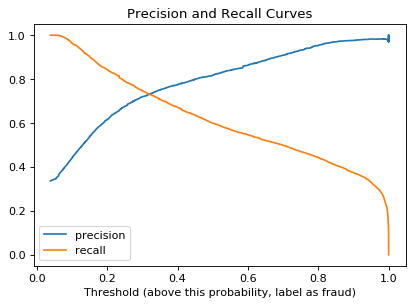

In [0]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm1.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [0]:
y_predict = lm1.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.8180,   Recall: 0.5991


In [0]:
y_pred_lr = lm1.predict(X_test)

In [0]:
cm_lr = metrics.confusion_matrix(y_test, y_pred_lr)
cm_lr

array([[13416,   779],
       [ 2323,  3482]])

In [0]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
a = sns.heatmap(pd.DataFrame(cm_lr), annot=True, fmt='g', cmap=cmap)
ax.xaxis.set_label_position("top")
plt.tight_layout()
# plt.title('The Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_lr))
print("Precision:",metrics.precision_score(y_test, y_pred_lr))
print("Recall:",metrics.recall_score(y_test, y_pred_lr))

Accuracy: 0.8449
Precision: 0.8171790659469608
Recall: 0.5998277347114557


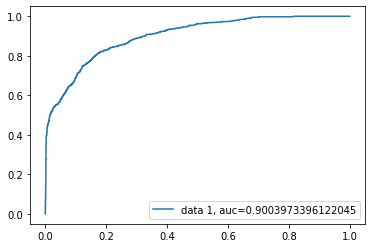

In [0]:
y_pred_proba_lr = lm1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_lr)
auc = metrics.roc_auc_score(y_test, y_pred_proba_lr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

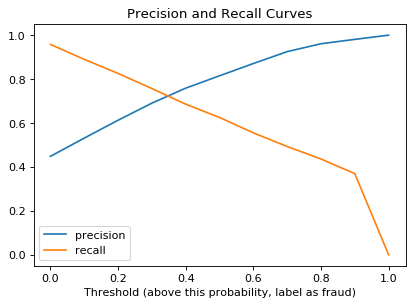

In [0]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, knn.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [0]:
Counter(y_resampled)

Counter({0.0: 1190424, 1.0: 1190424})

In [0]:
lm_bal = LogisticRegression(C=.35)
lm_bal.fit(X_resampled, y_resampled)

NameError: name 'X_resampled' is not defined

In [0]:
lm_bal.score(X_train, y_train)

0.8376718253921067

In [0]:
y_predict_bal = lm_bal.predict(X_test)

In [0]:
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lm_bal.score(X_resampled, y_resampled)))
print("Test set: {:6.2f}%".format(100*lm_bal.score(X_test, y_test)))

The score for logistic regression is
Training:  81.26%
Test set:  83.71%


In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict_bal))
print("Precision:",metrics.precision_score(y_test, y_predict_bal))
print("Recall:",metrics.recall_score(y_test, y_predict_bal))

Accuracy: 0.8371344994470671
Precision: 0.7076767426100734
Recall: 0.7542394433537125


In [0]:
cm_bal = metrics.confusion_matrix(y_test, y_predict_bal)
cm_bal

array([[207458,  30627],
       [ 24159,  74144]])

In [0]:
lm_bal.f1_score(y_test, y_predict_bal)

In [0]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm_bal.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

NameError: name 'lm_bal' is not defined

Text(0.5, 257.44, 'Predicted label')

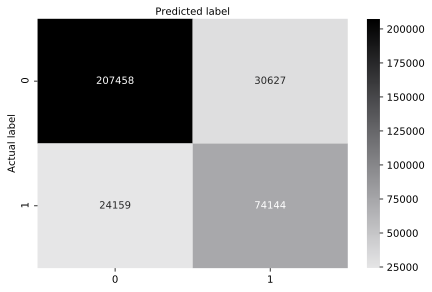

In [0]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
a = sns.heatmap(pd.DataFrame(cm_bal), annot=True, fmt='g', cmap=cmap)
ax.xaxis.set_label_position("top")
plt.tight_layout()
# plt.title('The Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


# Logistic Regression with undersampling

In [0]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X,y)

/home/minh/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/minh/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/minh/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is

In [0]:
# # Import ADASYN and create a new oversampled dataset

# ## Code goes here ##
# from imblearn.over_sampling import ADASYN
# X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X,y)

In [0]:
Counter(y_under)

Counter({0.0: 491516, 1.0: 491516})

In [0]:
lm_und = LogisticRegression(C=.55)
lm_und.fit(X_under, y_under)

/home/minh/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.55, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lm_und.score(X_under, y_under)))
print("Test set: {:6.2f}%".format(100*lm_und.score(X_test, y_test)))

The score for logistic regression is
Training:  81.24%
Test set:  83.70%


In [0]:
y_predict_und = lm_und.predict(X_test)

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_predict_und))
print("Precision:",metrics.precision_score(y_test, y_predict_und))
print("Recall:",metrics.recall_score(y_test, y_predict_und))

Accuracy: 0.8370482894752488
Precision: 0.7076235581697349
Recall: 0.7538732286908844


In [0]:
cm_und = metrics.confusion_matrix(y_test, y_predict_und)
cm_und

array([[207465,  30620],
       [ 24195,  74108]])

Text(0.5, 257.44, 'Predicted label')

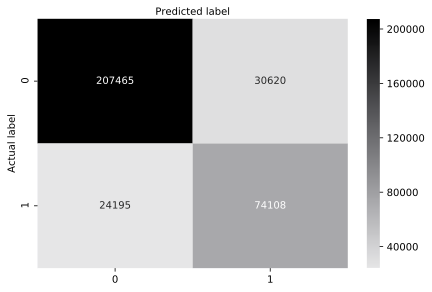

In [0]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
a = sns.heatmap(pd.DataFrame(cm_und), annot=True, fmt='g', cmap=cmap)
ax.xaxis.set_label_position("top")
plt.tight_layout()
# plt.title('The Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


In [0]:
lm_und.predict_proba(X_test.iloc[:10,])

array([[0.75408903, 0.24591097],
       [0.87888648, 0.12111352],
       [0.85775621, 0.14224379],
       [0.78561258, 0.21438742],
       [0.95658899, 0.04341101],
       [0.74848104, 0.25151896],
       [0.88073259, 0.11926741],
       [0.99057709, 0.00942291],
       [0.90195138, 0.09804862],
       [0.68715233, 0.31284767]])

Predict against the whole data set

In [0]:
pred_all = lm_und.predict_proba(X)

In [0]:
pf = lm_und.predict(X)

In [0]:
pf

array([0., 1., 1., ..., 0., 0., 0.])

In [0]:
run_model_df['prob0'] = pred_all[:,0]

In [0]:
run_model_df['prob1'] = pred_all[:,1]

In [0]:
run_model_df['prediction'] = pf

In [0]:
run_model_df.head()

,rodents_present,visit_num,rodents_present_250,rodents_present_500,rodents_present_1000,rodents_present_qtr_mile,rodents_present_half_mile,rodents_present_mile,rodents_present_restaurant_250_rest,rodents_present_restaurant_500_rest,...,non_rodent_violations_250_rest_any,non_rodent_violations_500_rest_any,non_rodent_violations_1000_rest_any,non_rodent_violations_qtr_mile_rest_any,non_rodent_violations_half_mile_rest_any,non_rodent_violations_mile_rest_any,block_score,prob0,prob1,prediction
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.546296,0.619322,0.380678,0.0
1,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.848214,0.454228,0.545772,1.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.719212,0.352344,0.647656,1.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.341772,0.453293,0.546707,1.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.177215,0.325261,0.674739,1.0


In [0]:
pred_all.shape

(1681940, 2)

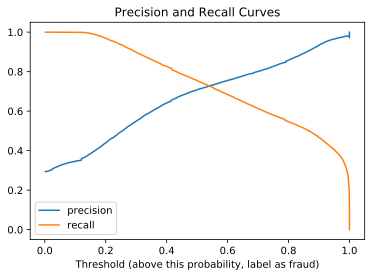

In [0]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lm_und.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [0]:
coef_dict = {}
for coef, feat in zip(lm_und.coef_[0,:],run_model_df.iloc[:,1:]):
    coef_dict[feat] = coef

In [0]:
coef_dict

{'block_score': -3.2956373930540055,
 'non_rodent_violations_1000_rest_any': -0.13380818039730352,
 'non_rodent_violations_250_rest_any': -0.13919819617505086,
 'non_rodent_violations_500_rest_any': -0.13090218356111227,
 'non_rodent_violations_half_mile_rest_any': -0.030270476700268795,
 'non_rodent_violations_mile_rest_any': -0.1877208024483637,
 'non_rodent_violations_qtr_mile_rest_any': 0.0623126954437951,
 'rodents_present_1000': 0.04518240277122691,
 'rodents_present_250': -0.3525817915017076,
 'rodents_present_500': 0.057390546965499147,
 'rodents_present_half_mile': 0.010098895000435608,
 'rodents_present_mile': 0.5317834338571931,
 'rodents_present_qtr_mile': -0.052664541273083,
 'rodents_present_restaurant_1000_rest': 0.0638811567286486,
 'rodents_present_restaurant_250_rest': 0.18117965450389123,
 'rodents_present_restaurant_500_rest': 0.12719802951692738,
 'rodents_present_restaurant_half_mile_rest': -0.10955361670153059,
 'rodents_present_restaurant_mile_rest': -0.01948497

In [0]:
lm_und.coef_

array([[ 1.66540887, -0.35258179,  0.05739055,  0.0451824 , -0.05266454,
         0.0100989 ,  0.53178343,  0.18117965,  0.12719803,  0.06388116,
        -0.07598149, -0.10955362, -0.01948498, -0.1391982 , -0.13090218,
        -0.13380818,  0.0623127 , -0.03027048, -0.1877208 , -3.29563739]])

# KNN

In [0]:
#Setup arrays to store training and test accuracies
neighbors = np.arange(1,11)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    #Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

In [0]:
# fit on train
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_under, y_under)

In [0]:
# test on test
y_pred_knn = knn.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_knn))

In [0]:
knn_cm = metrics.confusion_matrix(y_test, y_pred_knn)
knn_cm

In [0]:
y_pred_proba_knn = knn.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_knn))
print("Precision:",metrics.precision_score(y_test, y_pred_knn))
print("Recall:",metrics.recall_score(y_test, y_pred_knn))

Accuracy: 0.85
Precision: 0.8149562092971031
Recall: 0.6251507321274763


# KNN Cross Val

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
knn = KNeighborsClassifier(n_neighbors=100)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.848 0.837 0.868 0.827 0.843 0.841 0.842 0.844 0.875 0.841]


In [0]:
print(scores.mean())

0.8465999999999999


In [0]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8018000000000001, 0.8258999999999999, 0.8276999999999999, 0.8368, 0.8359, 0.8380000000000001, 0.8382, 0.8404999999999999, 0.8451000000000001, 0.8444, 0.8446999999999999, 0.8434999999999999, 0.8442000000000001, 0.8437000000000001, 0.8455, 0.8446000000000001, 0.8446, 0.8442000000000001, 0.8436, 0.845, 0.845, 0.8471, 0.8452999999999999, 0.8450999999999999, 0.8433999999999999, 0.8439, 0.8433999999999999, 0.8451000000000001, 0.8435, 0.8445]


Text(0, 0.5, 'Cross-Validated Accuracy')

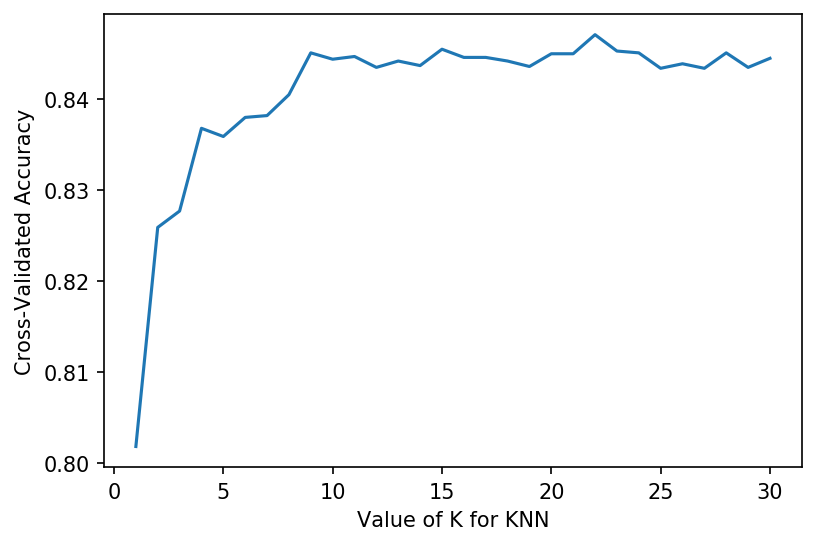

In [0]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(dpi=150)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Text(0, 0.5, 'Cross-Validated Accuracy')

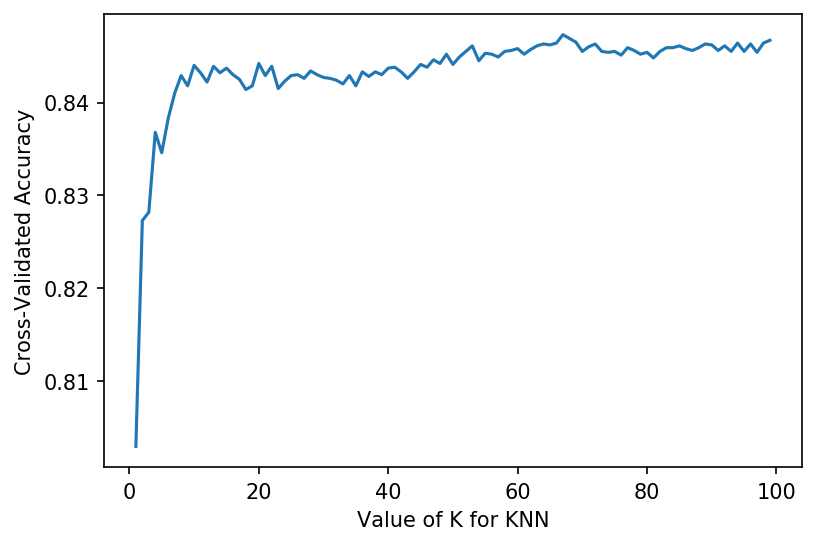

In [0]:
k_range = list(range(1, 100))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

plt.figure(dpi=150)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [0]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=10)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.8444


In [0]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.8396000000000001


In [0]:
# RandomizedSearchCV

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
# specify "parameter distributions" rather than a "parameter grid"

k_range = list(range(1, 100))

param_dist = dict(n_neighbors=k_range, weights=['uniform','distance'])

# n_iter controls the number of searches -- that is, how much of the potential grid do we search
# n_iter default = 10
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring='accuracy', \
                          n_iter=40)
rand.fit(X, y);

# examine the best model
print(rand.best_score_)
print(rand.best_params_)

0.8475999999999999
{'weights': 'uniform', 'n_neighbors': 97}


### KNN spit out decent accuracy scores but the recall was not great. Plus having to use k=10 for 1.3 million rows for a slightly better score than logistic regression is not worth the computational expense. k=97 gave the best overall accuracy score but k=97 is rediculous. Again, KNN loses out when it comes to computional expense and the poor recall.

In [0]:
# Trees and SVM

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [0]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

In [0]:
def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [0]:
linearsvc = LinearSVC()

# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X, y)

In [0]:
decisiontree = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times(decisiontree, X, y)

0.84485

In [0]:
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X, y)

0.8191066666666665

In [0]:
model_svm = svm.SVC(kernel='linear')

In [0]:
model_svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred_svm = model_svm.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
# 3b. Score the model
accuracy_score(y_test,y_pred_svm)

0.8372

In [0]:
# take a look at the predictions
confusion_matrix(y_test,y_pred_svm)

array([[1669,   90],
       [ 317,  424]])

In [0]:
# 1. Create a suppor vector classifier model
model_svm2 = svm.SVC(kernel='rbf', gamma = 8)

# 2. Fit a model on the training data
model_svm2.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=8, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
# 3a. Predict the values using the test data
y_pred_rbf = model_svm2.predict(X_test)

In [0]:
# 3b. Score the model
accuracy_score(y_test,y_pred_rbf)

0.832

In [0]:
# take a look at the predictions
confusion_matrix(y_test,y_pred_rbf)

array([[1724,   35],
       [ 367,  374]])

### Trees and SVM didn't score high enough for further investigation

In [0]:
# Bayes

In [0]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.3564

In [0]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
nbern = BernoulliNB()
nbern.fit(X_train,y_train)
nbern.score(X_test,y_test)

0.798

### Bayes didn't score high enough to warrant extra attention

# Summary

Logistic regression is the hero model. KNN was close but it was computationally expensive and didn't deliver a drastic
increase in accuracy and lagged a lot in the recall department.